In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import sys

spark = SparkSession.builder.appName("Stage1_Ingestion").getOrCreate()

#paths read from volumes
FACT_PATH = "/Volumes/capstone/default/datasets/global_export_fact_dataset.csv"
COUNTRY_PATH = "/Volumes/capstone/default/datasets/country_dataset.csv"
PRODUCT_PATH = "/Volumes/capstone/default/datasets/product_dataset.csv"

#target tables and their storage locations
BRONZE_FACT = "capstone.default.bronze_fact"
BRONZE_COUNTRY = "capstone.default.bronze_country"
BRONZE_PRODUCT = "capstone.default.bronze_product"


In [0]:
#columns of each table for validation purpose
FACT_COLS = ["Country_Name","Country_Code","Year","Month",
             "Product_Code","Product_Name","Product_Category",
             "Region","Export_Value_USD","Export_Units"]

COUNTRY_COLS = ["Country_Name","Country_Code","Region"]
PRODUCT_COLS = ["Product_Code","Product_Name","Product_Category"]

# **BRONZE LAYER**

In [0]:
print("INFO:STAGE 1 INGESTION STARTED")

INFO:STAGE 1 INGESTION STARTED


In [0]:
#safe loading function to check if the tables exists or not
def load_csv(path, expected_cols, name):
    try:
        df = spark.read.option("header", True).csv(path)
        print(f"INFO: {name} loaded successfully with {df.count()} records")

        missing_cols = [c for c in expected_cols if c not in df.columns]
        if missing_cols:
            print(f"ERROR: {name} missing columns: {missing_cols}")
            raise Exception(f"{name} schema invalid")

        print(f"INFO: {name} schema validated successfully")
        return df

    except Exception as e:
        print(f"ERROR: Failed to load {name} — {str(e)}")
        raise

In [0]:
# VALIDATIONS
#Validating country codes
def validate_country_codes(fact_df, country_df):
    invalid = fact_df.join(country_df, "Country_Code", "left_anti")
    c = invalid.count()
    if c > 0:
        print(f"WARNING: {c} invalid Country_Code records found in fact dataset")
    else:
        print("INFO: All Country Codes valid")

In [0]:
#Validate the product codes
def validate_product_codes(fact_df, product_df):
    invalid = fact_df.join(product_df, "Product_Code", "left_anti")
    c = invalid.count()
    if c > 0:
        print(f"WARNING: {c} invalid Product_Code records found in fact dataset")
    else:
        print("INFO: All Product Codes valid")

In [0]:
# function that saves the tables
def save_table(df, name):
    (
        df.write
        .mode("overwrite")
        .option("overwriteSchema", "true")
        .saveAsTable(name)
    )
    print(f"INFO: Saved bronze table -> {name}")

In [0]:
#RUN PIPELINE 
fact_df = load_csv(FACT_PATH, FACT_COLS, "FACT DATASET")
country_df = load_csv(COUNTRY_PATH, COUNTRY_COLS, "COUNTRY REFERENCE")
product_df = load_csv(PRODUCT_PATH, PRODUCT_COLS, "PRODUCT REFERENCE")

validate_country_codes(fact_df, country_df)
validate_product_codes(fact_df, product_df)

save_table(fact_df, BRONZE_FACT)
save_table(country_df, BRONZE_COUNTRY)
save_table(product_df, BRONZE_PRODUCT)

print("INFO:STAGE 1 INGESTION COMPLETED SUCCESSFULLY")

INFO: FACT DATASET loaded successfully with 7000 records
INFO: FACT DATASET schema validated successfully
INFO: COUNTRY REFERENCE loaded successfully with 10 records
INFO: COUNTRY REFERENCE schema validated successfully
INFO: PRODUCT REFERENCE loaded successfully with 10 records
INFO: PRODUCT REFERENCE schema validated successfully
INFO: All Country Codes valid
INFO: All Product Codes valid
INFO: Saved bronze table -> capstone.default.bronze_fact
INFO: Saved bronze table -> capstone.default.bronze_country
INFO: Saved bronze table -> capstone.default.bronze_product
INFO:STAGE 1 INGESTION COMPLETED SUCCESSFULLY


In [0]:
%sql
DESCRIBE TABLE capstone.default.bronze_fact;

col_name,data_type,comment
Country_Name,string,null
Country_Code,string,null
Year,string,null
Month,string,null
Product_Code,string,null
Product_Name,string,null
Product_Category,string,null
Region,string,null
Export_Value_USD,string,null
Export_Units,string,null


In [0]:
%sql
DESCRIBE TABLE capstone.default.BRONZE_COUNTRY;

col_name,data_type,comment
Country_Name,string,null
Country_Code,string,null
Region,string,null


In [0]:
%sql
DESCRIBE TABLE capstone.default.bronze_product;

col_name,data_type,comment
Product_Code,string,null
Product_Name,string,null
Product_Category,string,null


In [0]:
# verifying exceptions
# Intentionally passing wrong column names
try:
    df = load_csv(
        "/Volumes/capstone/default/datasets/global_export_fact_dataset.csv",
        ["Invalid_Column"],            # WRONG on purpose
        "FACT DATASET"
    )
except Exception as e:
    print("EXCEPTION RAISED:", e)


EXCEPTION RAISED: name 'load_csv' is not defined


# **SILVER LAYER**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType

spark = SparkSession.builder.appName("Silver_Layer").getOrCreate()

In [0]:
print("INFO: STAGE 2 — SILVER LAYER STARTED")

#SOURCE BRONZE TABLES
BRONZE_FACT = "capstone.default.bronze_fact"
BRONZE_COUNTRY = "capstone.default.bronze_country"
BRONZE_PRODUCT = "capstone.default.bronze_product"

# TARGET SILVER TABLE
SILVER_FACT = "capstone.default.silver_fact"

# LOAD BRONZE TABLES 
fact_df = spark.table(BRONZE_FACT)
country_df = spark.table(BRONZE_COUNTRY)
product_df = spark.table(BRONZE_PRODUCT)

print(f"INFO: Loaded Fact: {fact_df.count()} rows")
print(f"INFO: Loaded Country: {country_df.count()} rows")
print(f"INFO: Loaded Product: {product_df.count()} rows")

INFO: STAGE 2 — SILVER LAYER STARTED
INFO: Loaded Fact: 7000 rows
INFO: Loaded Country: 10 rows
INFO: Loaded Product: 10 rows


In [0]:
# REMOVE NULL RECORDS 
required_cols = [
    "Country_Code","Product_Code","Year","Export_Value_USD",
    "Country_Name","Product_Name","Product_Category","Region"
]

null_filtered_df = fact_df

for c in required_cols:
    null_filtered_df = null_filtered_df.filter(col(c).isNotNull())

print(f"INFO: After NULL removal → {null_filtered_df.count()} rows")

INFO: After NULL removal → 6603 rows


In [0]:
#REMOVE NEGATIVE EXPORT VALUES
non_negative_df = null_filtered_df.filter(col("Export_Value_USD") >= 0)

print(f"INFO: After removing negatives → {non_negative_df.count()} rows")

INFO: After removing negatives → 6043 rows


In [0]:
# STANDARDIZATION USING REFERENCE TABLES
# We trust reference datasets, not fact dataset text fields
# Overwrite country + region from country table
# Overwrite product_name + category from product table

joined_df = (
    non_negative_df.alias("f")
    .join(country_df.alias("c"), on="Country_Code", how="inner")
    .join(product_df.alias("p"), on="Product_Code", how="inner")
    .select(
        # Standardized trusted columns
        col("c.Country_Name").alias("Country_Name"),
        col("f.Country_Code"),
        col("f.Year"),
        col("f.Month"),
        col("p.Product_Code"),
        col("p.Product_Name").alias("Product_Name"),
        col("p.Product_Category").alias("Product_Category"),
        col("c.Region").alias("Region"),
        col("f.Export_Value_USD"),
        col("f.Export_Units")
    )
)

print(f"INFO: After standardization joins → {joined_df.count()} rows")

INFO: After standardization joins → 6043 rows


In [0]:
#REMOVE DUPLICATES
dedup_df = joined_df.dropDuplicates([
    "Country_Code","Product_Code","Year","Month","Export_Value_USD"
])

print(f"INFO: After removing duplicates → {dedup_df.count()} rows")

INFO: After removing duplicates → 6043 rows


In [0]:
# DATA TYPE STANDARDIZATION
final_df = (
    dedup_df
    .withColumn("Year", col("Year").cast(IntegerType()))
    .withColumn("Month", col("Month").cast(IntegerType()))
    .withColumn("Export_Value_USD", col("Export_Value_USD").cast(DoubleType()))
)

print("INFO: Data types standardized")

INFO: Data types standardized


In [0]:

#SAVE SILVER TABLE 
(
    final_df.write
    .mode("overwrite")
    .option("overwriteSchema", "true")
    .saveAsTable(SILVER_FACT)
)

print("SUCCESS: SILVER TABLE CREATED → capstone.default.silver_fact")
print("INFO: STAGE 2 COMPLETED SUCCESSFULLY")

SUCCESS: SILVER TABLE CREATED → capstone.default.silver_fact
INFO: STAGE 2 COMPLETED SUCCESSFULLY


In [0]:
#Verification of silver layer
SILVER_FACT = "capstone.default.silver_fact"
df = spark.table(SILVER_FACT)
display(df.filter(
    col("Country_Name").isNull() |
    col("Product_Name").isNull() |
    col("Region").isNull() |
    col("Export_Value_USD").isNull()
))


Country_Name,Country_Code,Year,Month,Product_Code,Product_Name,Product_Category,Region,Export_Value_USD,Export_Units


In [0]:
negative_count = df.filter(col("Export_Value_USD") < 0).count()
print("Negative Values Found:", negative_count)

Negative Values Found: 0


In [0]:
dup_count = (
    df.groupBy("Country_Code","Product_Code","Year","Month","Export_Value_USD")
      .count()
      .filter(col("count") > 1)
      .count()
)

print("Duplicate Records Found:", dup_count)


Duplicate Records Found: 0


In [0]:
%sql
SELECT * FROM capstone.default.silver_fact;


Country_Name,Country_Code,Year,Month,Product_Code,Product_Name,Product_Category,Region,Export_Value_USD,Export_Units
United States,USA,2022,3,P007,Automobiles,Automobile,North America,4500628.0,1875.0
Canada,CAN,2021,9,P008,Steel Materials,Metals,North America,2070259.0,651.0
India,IND,2020,2,P009,Processed Foods,Food,Asia,1319977.0,443.0
United Kingdom,GBR,2019,11,P001,Crude Oil,Fuel,Europe,2027161.0,819.0
Japan,JPN,2019,9,P010,Computer Hardware,Electronics,Asia,504984.0,577.0
India,IND,2022,6,P009,Processed Foods,Food,Asia,4083481.0,1639.0
Canada,CAN,2023,6,P002,Electronic Components,Electronics,North America,2566813.0,605.0
Japan,JPN,2021,6,P006,Pharmaceutical Products,Healthcare,Asia,4047125.0,358.0
Germany,DEU,2020,3,P002,Electronic Components,Electronics,Europe,4404886.0,736.0
United States,USA,2021,7,P003,Textile Materials,Textiles,North America,1182815.0,514.0


# GOLD LAYER

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, dense_rank, lag, when
from pyspark.sql.window import Window

spark = SparkSession.builder.appName("Gold_Layer").getOrCreate()

print("INFO:GOLD LAYER STARTED")

SILVER = "capstone.default.silver_fact"

# GOLD TABLES
GOLD_COUNTRY = "capstone.default.gold_country_performance"
GOLD_PRODUCT = "capstone.default.gold_product_performance"
GOLD_COUNTRY_GROWTH = "capstone.default.gold_country_growth_trends"
GOLD_PRODUCT_GROWTH = "capstone.default.gold_product_growth_trends"
GOLD_REGION = "capstone.default.gold_region_performance"
GOLD_REGION_PRODUCT = "capstone.default.gold_region_product_matrix"
GOLD_EMERGING = "capstone.default.gold_emerging_markets"

df = spark.table(SILVER)
print(f"INFO: Loaded Silver Fact: {df.count()} rows")


INFO:GOLD LAYER STARTED
INFO: Loaded Silver Fact: 6043 rows


In [0]:
#Top exporting countries
country_perf = (
    df.groupBy("Country_Name","Country_Code","Year")
      .agg(_sum("Export_Value_USD").alias("Total_Export_Value"))
)

w = Window.partitionBy("Year").orderBy(col("Total_Export_Value").desc())

country_perf = country_perf.withColumn("Rank", dense_rank().over(w))

country_perf.write.mode("overwrite").saveAsTable(GOLD_COUNTRY)
print("INFO: Country Performance Gold table created")


INFO: Country Performance Gold table created


In [0]:
%sql
select * from capstone.default.gold_country_performance;

Country_Name,Country_Code,Year,Total_Export_Value,Rank
France,FRA,2019,3.5631695E8,1
Australia,AUS,2019,3.31978977E8,2
Canada,CAN,2019,3.26378452E8,3
Brazil,BRA,2019,2.9657986E8,4
China,CHN,2019,2.94094372E8,5
Germany,DEU,2019,2.87110901E8,6
Japan,JPN,2019,2.68060519E8,7
United Kingdom,GBR,2019,2.66327829E8,8
United States,USA,2019,2.63017897E8,9
India,IND,2019,2.42309739E8,10


In [0]:
#Top exporting products
product_perf = (
    df.groupBy("Product_Category","Year")
      .agg(_sum("Export_Value_USD").alias("Total_Export_Value"))
)

w2 = Window.partitionBy("Year").orderBy(col("Total_Export_Value").desc())

product_perf = product_perf.withColumn("Rank", dense_rank().over(w2))

product_perf.write.mode("overwrite").saveAsTable(GOLD_PRODUCT)
print("INFO: Product Performance Gold table created")


INFO: Product Performance Gold table created


In [0]:
%sql
select * from capstone.default.gold_product_performance;

Product_Category,Year,Total_Export_Value,Rank
Electronics,2019,5.61016534E8,1
Fuel,2019,3.38204769E8,2
Metals,2019,3.07813585E8,3
Food,2019,3.04936929E8,4
Automobile,2019,2.94856017E8,5
Agriculture,2019,2.93715715E8,6
Machinery,2019,2.87870943E8,7
Healthcare,2019,2.77655483E8,8
Textiles,2019,2.66105521E8,9
Electronics,2020,5.79381771E8,1


In [0]:
# Country growth/decline analysis
country_growth = country_perf

w3 = Window.partitionBy("Country_Code").orderBy("Year")

country_growth = country_growth.withColumn(
    "Prev_Year_Export",
    lag("Total_Export_Value").over(w3)
)

country_growth = country_growth.withColumn(
    "YoY_Growth_Percent",
    ((col("Total_Export_Value") - col("Prev_Year_Export")) /
      col("Prev_Year_Export")) * 100
)

country_growth.write.mode("overwrite").saveAsTable(GOLD_COUNTRY_GROWTH)
print("INFO: Country Growth Trends Gold table created")


INFO: Country Growth Trends Gold table created


In [0]:
%sql
select * from capstone.default.gold_country_growth_trends;

Country_Name,Country_Code,Year,Total_Export_Value,Rank,Prev_Year_Export,YoY_Growth_Percent
Australia,AUS,2019,3.31978977E8,2,null,null
Australia,AUS,2020,3.14664696E8,5,3.31978977E8,-5.215475135342682
Australia,AUS,2021,2.60960791E8,10,3.14664696E8,-17.06702584772967
Australia,AUS,2022,3.29161883E8,4,2.60960791E8,26.1346126897661
Australia,AUS,2023,3.12606967E8,3,3.29161883E8,-5.029414660384599
Brazil,BRA,2019,2.9657986E8,4,null,null
Brazil,BRA,2020,2.74651355E8,9,2.9657986E8,-7.393794372955736
Brazil,BRA,2021,2.74401507E8,8,2.74651355E8,-0.09096914886875399
Brazil,BRA,2022,3.15621049E8,5,2.74401507E8,15.02161648113689
Brazil,BRA,2023,2.7387007E8,7,3.15621049E8,-13.228198541346334


In [0]:
#Product growth/decline analysis
product_growth = product_perf

w4 = Window.partitionBy("Product_Category").orderBy("Year")

product_growth = product_growth.withColumn(
    "Prev_Year_Export",
    lag("Total_Export_Value").over(w4)
)

product_growth = product_growth.withColumn(
    "YoY_Growth_Percent",
    ((col("Total_Export_Value") - col("Prev_Year_Export")) /
      col("Prev_Year_Export")) * 100
)

product_growth.write.mode("overwrite").saveAsTable(GOLD_PRODUCT_GROWTH)
print("INFO: Product Growth Trends Gold table created")


INFO: Product Growth Trends Gold table created


In [0]:
%sql
select * from capstone.default.gold_product_growth_trends;

Product_Category,Year,Total_Export_Value,Rank,Prev_Year_Export,YoY_Growth_Percent
Agriculture,2019,2.93715715E8,6,null,null
Agriculture,2020,3.35534646E8,3,2.93715715E8,14.23789360402456
Agriculture,2021,2.95052584E8,6,3.35534646E8,-12.064942467967972
Agriculture,2022,2.53152616E8,9,2.95052584E8,-14.200847669919067
Agriculture,2023,2.56084808E8,9,2.53152616E8,1.1582704719116945
Automobile,2019,2.94856017E8,5,null,null
Automobile,2020,3.27931131E8,4,2.94856017E8,11.217378005889566
Automobile,2021,3.06174098E8,4,3.27931131E8,-6.634634819101698
Automobile,2022,3.25572392E8,3,3.06174098E8,6.335707078656928
Automobile,2023,2.7434694E8,7,3.25572392E8,-15.733966779345346


In [0]:
# Region-wise performance
region_perf = (
    df.groupBy("Region","Year")
      .agg(_sum("Export_Value_USD").alias("Total_Export_Value"))
)

region_perf.write.mode("overwrite").saveAsTable(GOLD_REGION)
print("INFO: Region Performance Gold table created")


INFO: Region Performance Gold table created


In [0]:
%sql
select * from capstone.default.gold_region_performance;

Region,Year,Total_Export_Value
Europe,2020,8.99080408E8
Asia,2023,8.8005729E8
Asia,2022,9.50883157E8
South America,2022,3.15621049E8
Europe,2021,9.15751163E8
Asia,2021,9.44982418E8
Europe,2023,9.19207197E8
North America,2022,6.30952652E8
South America,2021,2.74401507E8
Oceania,2022,3.29161883E8


In [0]:
#Region vs product performance
region_product = (
    df.groupBy("Region","Product_Category","Year")
      .agg(_sum("Export_Value_USD").alias("Total_Export_Value"))
)

region_product.write.mode("overwrite").saveAsTable(GOLD_REGION_PRODUCT)
print("INFO: Region Product Comparison Gold table created")


INFO: Region Product Comparison Gold table created


In [0]:
%sql
select * from capstone.default.gold_region_product_matrix;

Region,Product_Category,Year,Total_Export_Value
Asia,Metals,2019,9.7479338E7
Asia,Automobile,2022,9.0910856E7
Oceania,Textiles,2022,1.6809355E7
Oceania,Electronics,2020,7.845915E7
Europe,Agriculture,2019,8.0014281E7
Europe,Food,2019,9.968579E7
South America,Fuel,2020,4.2914959E7
North America,Agriculture,2022,4.418334E7
North America,Automobile,2022,8.3682878E7
South America,Food,2019,2.5325735E7


In [0]:
#Emerging markets identification
emerging = country_growth.filter(col("YoY_Growth_Percent") > 10)

emerging_summary = (
    emerging.groupBy("Country_Name","Country_Code")
    .agg(
        _sum(when(col("YoY_Growth_Percent") > 10, 1).otherwise(0))
        .alias("Years_Growing")
    )
    .withColumn("Emerging_Flag", when(col("Years_Growing") >= 2, "YES").otherwise("NO"))
)

emerging_summary.write.mode("overwrite").saveAsTable(GOLD_EMERGING)
print("INFO: Emerging Markets Gold table created")


INFO: Emerging Markets Gold table created


In [0]:
%sql
select * from capstone.default.gold_emerging_markets;

Country_Name,Country_Code,Years_Growing,Emerging_Flag
Australia,AUS,1,NO
Brazil,BRA,1,NO
China,CHN,1,NO
Germany,DEU,1,NO
United Kingdom,GBR,2,YES
India,IND,1,NO
Japan,JPN,2,YES
United States,USA,1,NO


In [0]:
%pip install networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


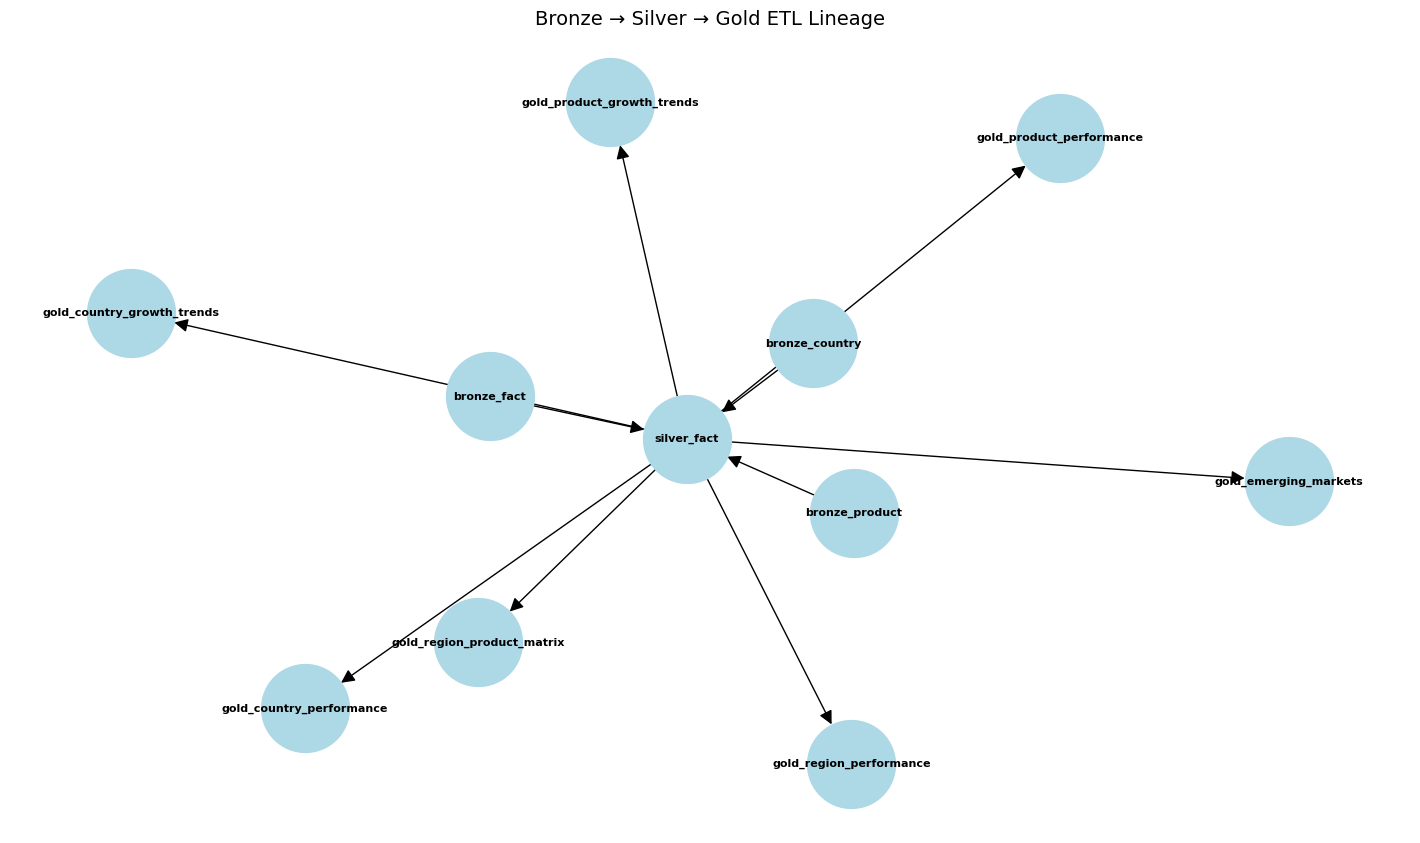

In [0]:


import networkx as nx
import matplotlib.pyplot as plt

# Create a Directed Graph
G = nx.DiGraph()

# Bronze Layer
G.add_node("bronze_fact")
G.add_node("bronze_country")
G.add_node("bronze_product")

# Silver Layer
G.add_node("silver_fact")

# Gold Layer
gold_tables = [
    "gold_country_performance",
    "gold_country_growth_trends",
    "gold_region_performance",
    "gold_region_product_matrix",
    "gold_product_performance",
    "gold_product_growth_trends",
    "gold_emerging_markets"
]

for t in gold_tables:
    G.add_node(t)

# ETL FLOW 

# Bronze → Silver
G.add_edge("bronze_fact", "silver_fact")
G.add_edge("bronze_country", "silver_fact")
G.add_edge("bronze_product", "silver_fact")

# Silver → Gold
for t in gold_tables:
    G.add_edge("silver_fact", t)

# DRAW GRAPH
plt.figure(figsize=(14,8))
pos = nx.spring_layout(G, k=0.7)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=4000,
    node_color="lightblue",
    font_size=8,
    font_weight="bold",
    arrowsize=20
)

plt.title("Bronze → Silver → Gold ETL Lineage", fontsize=14)
plt.show()


VALIDATIONS

In [0]:
%sql
--Total global export value
select sum(Total_Export_Value) from gold_country_performance;

sum(Total_Export_Value)
1.496751909E10


In [0]:
%sql
--Number of exporting countries
select count(distinct(Country_Code)) from gold_country_growth_trends;

count(DISTINCT(Country_Code))
10


In [0]:
%sql
--Highest Exporting Continent
select Region, sum(Total_Export_Value) AS total_export_value
from gold_region_performance
group by Region
order by total_export_value DESC limit 1;


Region,total_export_value
Europe,4.502490586E9


In [0]:
%sql
--Number of emerging markets
select count(distinct(Country_Code)) from gold_emerging_markets where EMERGING_FLAG='YES';

count(DISTINCT(Country_Code))
2


In [0]:
%sql
--Country with highest Export
select Country_Name, sum(Total_Export_Value) AS total_export_value
from gold_country_performance
group by Country_Name
order by total_export_value DESC limit 1;


Country_Name,total_export_value
France,1.585154521E9
